In [1]:
from datetime import datetime

import numpy as np
import talib as ta

from btopt.data.bar import Bar
from btopt.data.dataloader import CSVDataLoader
from btopt.engine import Engine
from btopt.log_config import logger_main
from btopt.order import Order
from btopt.strategy.strategy import Strategy
from btopt.util.decimal import ExtendedDecimal

In [2]:
class Empty(Strategy):
    def __init__(
        self,
    ) -> None:
        super().__init__()

    def on_data(self, bar: Bar) -> None:
        x = Engine()
        x._dataview.data

        if len(self) <= 1:
            return

        self.debug(f"PRIMARY: {(self.data.close[1])}, TIMEFRAME: {self.datas.keys()}")
        self.debug(f"TIMEFRAMES: {self.datas[self._primary_symbol].timeframes}")
        # self.debug(
        #     f"SECONDARY: {(self.datas[self._primary_symbol].get(value="close"))}, TIMEFRAME: {self.datas[self._primary_symbol][1]._timeframe}"
        # )

        # if len(self) > 100:
        #     raise

    @staticmethod
    def debug(message):
        logger_main.info(message)


def parse_date(epoch):
    return datetime.fromtimestamp(epoch / 1_000_000_000).strftime("%Y-%m-%d %H:%M:%S")


class SimpleMovingAverageCrossover(Strategy):
    def __init__(self, fast_period: int = 10, slow_period: int = 20, risk_percent=0.01):
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.risk_percent = risk_percent
        self.warmup_period = 1

        self.fast_ma = None
        self.slow_ma = None

        self.total = 0

    def on_data(self) -> None:
        bar = self.datas[self._primary_symbol].get(index=0)
        close_prices = self.datas[self._primary_symbol].get(
            size=self.slow_period, value="close"
        )[::-1]

        if len(close_prices) < self.slow_period:
            return

        fast_ma = ta.SMA(
            np.array(close_prices).astype(float), timeperiod=self.fast_period
        )[-1]
        slow_ma = ta.SMA(
            np.array(close_prices).astype(float), timeperiod=self.slow_period
        )[-1]

        current_position = self.get_current_position(bar.ticker)
        if (self.fast_ma is not None) and (self.slow_ma is not None):
            prev_diff = self.fast_ma - self.slow_ma
            diff = fast_ma - slow_ma

            if (diff > 0) and (prev_diff <= 0):
                # Bullish crossover
                if current_position <= 0:
                    position_size = self.calculate_position_size(
                        bar.close,
                        self.risk_percent,
                        (bar.close * 0.99),
                    )

                    logger_main.info(
                        f"\n\nDATE: {parse_date(bar.timestamp)}\nENTRY: {bar.close}. \nSL : {(bar.close * 0.99)}\nBALANCE: {self._engine.get_account_value()}\n"
                    )

                    size = abs(current_position) + position_size
                    self.buy(bar.ticker, size)
                    self.total += 1
            elif (diff < 0) and (prev_diff >= 0):
                # Bearish crossover
                if current_position >= 0:
                    position_size = self.calculate_position_size(
                        bar.close,
                        self.risk_percent,
                        (bar.close * 1.01),
                    )

                    logger_main.info(
                        f"\n\nDATE: {parse_date(bar.timestamp)}\nENTRY: {bar.close}. \nSL : {(bar.close * 1.01)}\nBALANCE: {self._engine.get_account_value()}\n"
                    )

                    size = current_position + position_size
                    self.sell(bar.ticker, size)
                    self.total += 1

        # Update MA values for next iteration
        self.fast_ma = fast_ma
        self.slow_ma = slow_ma

    def on_order_update(self, order: Order) -> None:
        logger_main.info(f"Order update: {order}")

    def on_trade_update(self, trade) -> None:
        logger_main.info(f"Trade update: {trade}")

In [3]:
def run_backtest():
    # Initialize the engine
    engine = Engine()

    # Load data
    symbol = "EURUSD"
    start_date = "2021-01-01"
    end_date = "2023-01-01"

    ctf, htf = "4h", "1d"

    dataloader = CSVDataLoader(symbol, "1m", start_date=start_date, end_date=end_date)

    # engine.resample_data(dataloader, ctf)
    engine.resample_data(dataloader, htf)

    # # Create and add the strategy
    # strategy = SimpleMovingAverageCrossover(
    #     "SMA Crossover", fast_period=10, slow_period=20
    # )

    # engine.add_strategy(Empty, ctf, htf)
    engine.add_strategy(SimpleMovingAverageCrossover, fast_period=10, slow_period=20)

    # Set up the backtest configuration

    initial_capital = ExtendedDecimal("100000")
    commission_rate = ExtendedDecimal("0.000")  # 0.1% commission
    config = {
        "initial_capital": initial_capital,
        "commission_rate": commission_rate,
    }
    engine.set_config(config)

    # Run the backtest
    try:
        logger_main.info("Starting backtest")
        reporter = engine.run()

        return reporter
    except Exception as e:
        logger_main.error(f"Error during backtest: {e}", exc_info=True)

In [4]:
reporter = run_backtest()

/Users/jerryinyang/Code/btopt/btopt/portfolio.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.metrics = pd.concat([self.metrics, new_row], ignore_index=True)


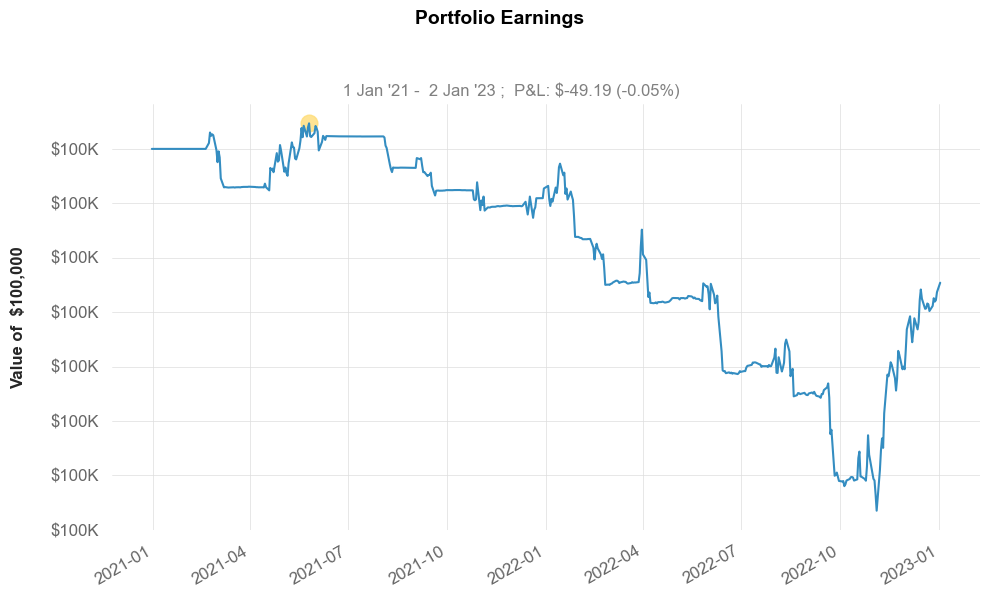

In [5]:
metrics = reporter.plot_equity_curve()

In [6]:
metrics